# Анализ лояльности пользователей Яндекс Афиша

- Автор: Карпов Даниил
- Дата: 23.01.2026

## Цели и задачи
### Цели
Проанализировать лояльность пользователей Сервиса. Установить категорию пользователей, с большей вероятностью возвращающихся на платформу и делающих заказы повторно

### Задачи
1. Загрузка данных и знакомство с ними;
2. Предобработка данных: перевод валюты, анализ типов данных, обработка пропусков, обработка дубликатов;
3. Создание профиля пользователя;
4. Исследовательский анализ данных;
5. Формирование общих выводов и рекомендаций;
6. Загрузка проекта в Git.

## Данные

В распоряжении есть информация из двух датасетов:

- `df` - основные данные, составленные из запроса SQL к базе данных `data-analyst-afisha`;
- `final_tickets_tenge_df.csv` - информация о курсе рубля к тенге.

### Описание датафрейма `df`

- `user_id` - уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` - тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` - уникальный идентификатор заказа;
- `order_dt` - дата создания заказа;
- `order_ts` - дата и время создания заказа;
- `currency_code` - валюта оплаты;
- `revenue` - выручка от заказа;
- `tickets_count` - количество купленных билетов;
- `days_since_prev` - количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` - уникальный идентификатор мероприятия;
- `service_name` - название билетного оператора;
- `event_type_main` - основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` - название региона, в котором прошло мероприятие;
- `city_name` - название города, в котором прошло мероприятие.
    
## Содержание проекта

- [Загрузка данных и знакомство с ними](#1)
    - [Подключение к БД и загрузка данных в датафрейм](#1.1)
    - [Общая информация о данных](#1.2)
- [Предобработка данных](#2)
    - [Приведение выручки к значениям в рублях](#2.1)
    - [Предобработка данных](#2.2)
- [Создание профиля пользователя](#3)
    - [Построение профиля пользователя](#3.1)
    - [Расчет статистик профиля](#3.2)
- [Исследовательский анализ данных](#4)
    - [Исследование признаков первого заказа](#4.1)
        - [Изучение распределения пользователей по признакам](#4.1.1)
        - [Анализ возвратов пользователей](#4.1.2)
        - [Анализ продуктовых гипотез](#4.1.3)
    - [Исследование поведения пользователей через показатели выручки и состава заказа](#4.2)
        - [Анализ связи средней выручки с повторными заказами](#4.2.1)
        - [Анализ средней выручки среди вернувшихся пользователей](#4.2.2)
        - [Анализ влияния среднего количества билетов на вероятность повторной покупки](#4.2.3)
    - [Исследование временных характеристик первого заказа и их влияния на повторные покупки](#4.3)
        - [Анализ влияния среднего количества билетов на вероятность повторной покупки](#4.3.1)
        - [Анализ влияния среднего интервала между заказами на удержание клиентов](#4.3.2)
    - [Корреляционный анализ количества покупок и признаков пользователя](#4.4)
        - [Проведение корреляционного анализа](#4.4.1)
- [Общие выводы и рекомендации](#5)
    - [Обзор обрабатываемых данных](#5.1)
    - [Основные результаты анализа](#5.2)
    - [Основные рекомендации](#5.3)
- [Публикация проекта в Git](#5)

## 1. Загрузка данных и знакомство с ними <a id='1'></a>

### 1.1. Подключение к БД и загрузка данных в датафрейм <a id='1.1'></a>

In [1]:
# импортируем необходимые библиотеки
import os

from dotenv import load_dotenv

import pandas as pd

from sqlalchemy import create_engine

import matplotlib.pyplot as plt

import seaborn as sns

from phik import phik_matrix

In [2]:
# создадим словарь с данными для подключения к БД
load_dotenv()
db_config = {'user': os.getenv('user'), # имя пользователя
             'pwd': os.getenv('password'), # пароль
             'host': os.getenv('host'),
             'port': os.getenv('port'), # порт подключения
             'db': os.getenv('name') # название базы данных
             }

In [3]:
# создадим строку с данными для подключения к БД по шаблону
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
# создадим движок, отвечающий за подключение к БД
engine = create_engine(connection_string)

In [5]:
# сформируем SQL-запрос к БД
query = '''
select
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk AS order_dt,
  p.created_ts_msk as order_ts,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  extract(DAY from p.created_dt_msk - (lag(p.created_dt_msk) over (
    partition by p.user_id 
    order by p.created_dt_msk)))::int as days_since_prev,
  p.event_id,
  e.event_name_code as event_name,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name
from afisha.purchases p
left join afisha.events e on p.event_id = e.event_id
left join afisha.city c on e.city_id = c.city_id
left join afisha.regions r on c.region_id = r.region_id
where p.device_type_canonical in ('mobile', 'desktop') and 
  e.event_type_main != 'фильм'
order by p.user_id 
'''

In [6]:
# создадим DataFrame на основе результата запроса к БД
df = pd.read_sql_query(query, con=engine)
# зафиксируем объем сырых данных
initial_len = len(df)

### 1.2. Общая информация о данных <a id='1.2'></a>

In [7]:
# выведем первые строки
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [8]:
#выведем информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [9]:
# проверим размах значений столбца tickets_count
print(df['tickets_count'].max())
print(df['tickets_count'].min())

57
1


---
**Первичный анализ данных:**
- датасет содержит 15 полей и 290611 строк;
- в столбце `days_since_prev` есть пропуски, но все они, скорее всего могут быть объяснены механизмом формирования столбца в SQL-запросе;
- названия столбцов в нижнем регистре и без пробелов по краям - редактировать ничего не нужно;
- на столбец с количеством билетов `tickets_count` лучше выделить 1 байт и хранить в `int8`;
- тип данных в остальных полях выбран согласно содержанию. 

In [10]:
# преобразуем тип данных в столбце tickets_count
df['tickets_count'] = df['tickets_count'].astype('int8')

In [11]:
# проверим тип
df['tickets_count'].dtype

dtype('int8')

## 2. Предобработка данных <a id='2'></a>

### 2.1 Приведение выручки к значениям в рублях <a id='2.1'></a>

In [12]:
# создадим DataFrame, содержащий информацию о курсах валют
rub_kzt_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [13]:
# ознакомимся с датасетом
rub_kzt_df.head(5)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [14]:
rub_kzt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [15]:
# приведем к типу datetime для корректного объединения
rub_kzt_df['data'] = pd.to_datetime(rub_kzt_df['data'], format = "%Y-%m-%d")

In [16]:
rub_kzt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [17]:
# создадим промежуточный объединенный датафрейм
test_df = df.merge(rub_kzt_df, left_on='order_dt', right_on='data', how = 'left')
test_df['revenue_rub'] = test_df['revenue']

In [18]:
# воспользуемся маской для валюты в тенге и произведем перевод
mask = test_df['currency_code'] == test_df['cdx']
test_df.loc[mask, 'revenue_rub'] = (
    test_df.loc[mask, 'revenue'] / test_df.loc[mask, 'nominal'] * test_df.loc[mask, 'curs']
)

In [19]:
# создадим новое поле с валютой в рублях в исходном датафрейме
df['revenue_rub'] = test_df['revenue_rub']

In [20]:
# убедимся в переводе
df[df['currency_code'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.296591


---
**Промежуточный итог**  
В исходном датафрейме `df` создано поле `revenue_rub` с валютой, переведенной в рубли.

### 2.2 Предобработка данных <a id='2.2'></a>

**Анализ пропусков**  
Определим абсолютное количество пропусков в полях:

In [21]:
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

Определим процент пропусков в полях:

In [22]:
round(df.isna().mean() * 100, 2)

user_id                  0.00
device_type_canonical    0.00
order_id                 0.00
order_dt                 0.00
order_ts                 0.00
currency_code            0.00
revenue                  0.00
tickets_count            0.00
days_since_prev          7.55
event_id                 0.00
event_name               0.00
event_type_main          0.00
service_name             0.00
region_name              0.00
city_name                0.00
revenue_rub              0.00
dtype: float64

Пропуски есть только в столбце `days_since_prev`, что связано с формированием SQL-запроса. Заполнять эти пропуски не стоит, они имеют смысл в контексте данных.

**Анализ типов данных**  
При знакомстве с данными выяснили, что для столбца `tickets_count` подходит тип `int8`, поскольку значения целочисленны, а размах от 1 до 57.

In [23]:
# преобразуем тип данных в столбце tickets_count
df['tickets_count'] = df['tickets_count'].astype('int8')

In [24]:
# проверим тип
df['tickets_count'].dtype

dtype('int8')

Также проанализируем флаги в категориальных столбцах, которые могут обозначать пропуски в данных:

In [25]:
# основные категориальные столбцы
columns = [
    'device_type_canonical', 
    'currency_code',
    'event_type_main',
    'service_name',
    'region_name',
    'city_name'
]
# вывод частоты уникальных значений
for col in columns:
    print(f"Уникальные значения столбца {col}:")
    print(df[col].value_counts(dropna=False))
    print()

Уникальные значения столбца device_type_canonical:
mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64

Уникальные значения столбца currency_code:
rub    285542
kzt      5069
Name: currency_code, dtype: int64

Уникальные значения столбца event_type_main:
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64

Уникальные значения столбца service_name:
Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   

Флагов, обозначающих пропуски в категориальных столбцах, не выявлено.

**Анализ дубликатов**  
Определим количество явных дубликатов в исходном датафрейме:

In [26]:
df.duplicated().sum()

0

Проведем нормализацию данных в основных категориальных столбцах:

In [27]:
for col in columns:
    df[col] = df[col].str.lower().str.strip()
df.duplicated().sum()

0

Неявных дубликатов после нормализации не выявлено

In [28]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,каменевский регион,глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,мой билет,каменевский регион,глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,за билетом!,каменевский регион,глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,лови билет!,североярская область,озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,билеты без проблем,озернинский край,родниковецк,1390.41


**Анализ значений столбца `revenue_rub`**  
Определим основные статистики по выручке в рублях:

In [29]:
df['revenue_rub'].describe()

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Выделим некоторые свойства данных столбца `revenue_rub`:
- высокий размах данных;
- СКО превышает среднее - высокий разброс;
- среднее значение больше медианы: свидетельствует о положительной скошенности (правый хвост) в распределении данных.

---
Перед анализом распределения данных в численных столбцах напишем функции для автоматизации построения различных графиков:

In [30]:
# функция построения столбчатой диаграммы
def plot_bar(data, kind, width, height, rot, title, xlabel, ylabel, legend=False):
    """
    Функция строит столбчатую диаграмму, используя аргументы:
    data - датасет, по которому строится диаграмма
    kind - тип диаграммы
    width, height - ширина, высота контейнера для графика
    rot - угол поворота подписей оси абсцисс
    title - название графика
    xlabel - название оси абсцисс
    legend - показывать или нет легенду, по умолчанию `False`
    """
    data.plot(
        figsize=(width, height),
        kind=kind,
        rot=rot,
        legend=legend,
        title=title
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

In [31]:
# функция построения диаграммы размаха
def plot_boxplot(data, width, height, vert, title, xlabel):
    """
    Функция строит диаграмму размаха по следующим аргументам:
    data - столбец с данными
    width, height - ширина, высота окна для графика
    vert - вертикально или горизонтально расположенная диаграмма
    title - название графика
    xlabel - подпись оси абсцисс
    """
    data.plot(
        kind='box',
        figsize=(width, height),
        vert=vert
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid()
    plt.show()

In [32]:
# функция построения гистрограммы
def plot_hist(data, width, height, rot, bins, title, xlabel):
    """
    Функция строит гистограмму по следующим аргументам:
    data - столбец с данными
    width, height - ширина, высота окна для графика
    rot - угол поворота подписей оси абсцисс
    bins - количество интервалов для построения
    title - название графика
    xlabel - подпись оси абсцисс
    """
    data.plot(
        kind='hist',
        figsize=(width, height),
        rot=rot,
        bins=bins
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid()
    plt.show()

---

Продолжим анализ `revenue_rub`. Построим диаграмму размаха данных в этом столбце.

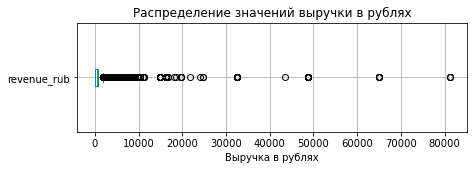

In [33]:
plot_boxplot(
    data=df['revenue_rub'], 
    width=7, 
    height=2,
    vert=False,
    title='Распределение значений выручки в рублях',
    xlabel='Выручка в рублях'
)

По диаграмме размаха и основным статистикам можно судить об экстремальных выбросах и наличии отрицательных значений.  
- Смысл данных в столбце `revenue_rub` не предполагает отрицательных значений. Можно предположить, что это возвраты (т.е. "выручка", взятая с обратным знаком), но поскольку наиболее вероятная выручка (медиана) в районе 350, а наименьшее отрицательное значение в районе -91, можно сделать вывод, что это ошибка данных, которую надо удалить.
- Максимальное значение в столбце в десятки раз больше медианы. Ограничимся выборкой, равной 99му процентилю. Это позволит учесть 99% данных, но существенно исправит распределение как визуально, так и численно.

In [34]:
# воспользуемся маской для удаления строк с отрицательной выручкой и оставим 99% данных по выручке
mask = (df['revenue_rub'] >= 0) & (df['revenue_rub'] <= df['revenue_rub'].quantile(.99))
df = df[mask]

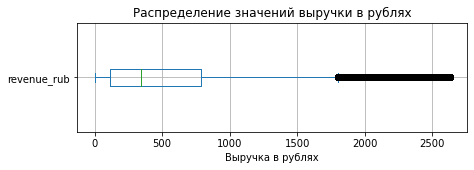

In [35]:
plot_boxplot(
    data=df['revenue_rub'], 
    width=7, 
    height=2,
    vert=False,
    title='Распределение значений выручки в рублях',
    xlabel='Выручка в рублях'
)

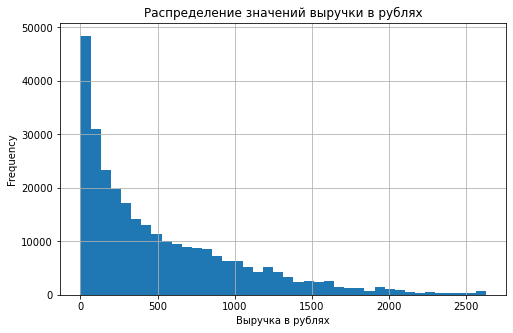

In [36]:
plot_hist(
    data=df['revenue_rub'], 
    width=8, 
    height=5,
    rot=0,
    bins=40,
    title='Распределение значений выручки в рублях',
    xlabel='Выручка в рублях'
)

Заметим, что распределение имеет положительную скошенность. Чаще значения встречаются в области малой выручки (< 500 руб).

In [37]:
# основные статистики по отфильтрованному полю revenue_rub
df['revenue_rub'].describe()

count    287405.000000
mean        518.719256
std         511.951842
min           0.000000
25%         112.600000
50%         344.830000
75%         788.900000
max        2628.421739
Name: revenue_rub, dtype: float64

Определим процент удаленных данных:

In [38]:
final_len = len(df)
round((initial_len - final_len) / initial_len * 100, 2)

1.1

Удалено порядка 1.1% данных.

**Анализ значений столбца `tickets_count`**  
Определим основные статистики по количеству билетов:

In [39]:
df['tickets_count'].describe()

count    287405.000000
mean          2.741323
std           1.163087
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

Выделим некоторые свойства данных столбца `revenue_rub`:
- высокий размах данных;
- СКО превышает среднее - высокий разброс;
- среднее значение больше медианы: свидетельствует о положительной скошенности (правый хвост) в распределении данных.

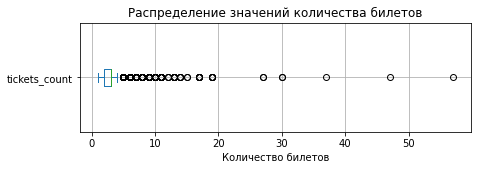

In [40]:
plot_boxplot(
    data=df['tickets_count'], 
    width=7, 
    height=2,
    vert=False,
    title='Распределение значений количества билетов',
    xlabel='Количество билетов'
)

По диаграмме размаха и общим статистикам можно судить о наличии экстремальных выбросов, искажающих усредненную картинку по количеству купленных билетов. Поскольку основной задачей анализа является оценка поведения среднего пользователя, от аномалий лучше избавиться. Отфильтруем датасет по 99му процентилю в поле `tickets_count`:

In [41]:
# воспользуемся маской для фильтрации
mask = df['tickets_count'] <= df['tickets_count'].quantile(.99)
df = df[mask]

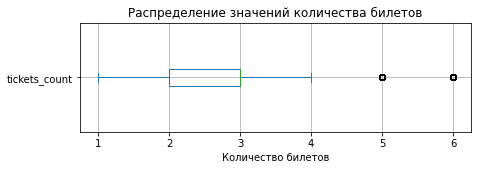

In [42]:
plot_boxplot(
    data=df['tickets_count'], 
    width=7, 
    height=2,
    vert=False,
    title='Распределение значений количества билетов',
    xlabel='Количество билетов'
)

Распределение без правого хвоста.

Определим процент удаленных данных:

In [43]:
final_len = len(df)
round((initial_len - final_len) / initial_len * 100, 2)

1.17

После фильтрации по выручке и количеству билетов удалено порядка 1.17% данных.

In [44]:
len(df)

287225

**Вывод по обработке данных**
- в исходном датафрейме `df` создано поле `revenue_rub` с валютой, переведенной в рубли;
- данные в поле `tickets_count` приведены к типу `int8`;
- явных и неявных дубликатов не найдено;
- пропуски содержатся в столбце `days_since_prev` вследствие логики SQL-запроса;
- удалено 3386 строк (порядка 1.17% данных) после фильтрации полей `revenue_rub` и `tickets_count` по 99му процентилю и удаления отрицательных значений выручки.

## 3. Создание профиля пользователя <a id='3'></a>

### 3.1 Построение профиля пользователя <a id='3.1'></a>

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287225 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287225 non-null  object        
 1   device_type_canonical  287225 non-null  object        
 2   order_id               287225 non-null  int64         
 3   order_dt               287225 non-null  datetime64[ns]
 4   order_ts               287225 non-null  datetime64[ns]
 5   currency_code          287225 non-null  object        
 6   revenue                287225 non-null  float64       
 7   tickets_count          287225 non-null  int8          
 8   days_since_prev        265536 non-null  float64       
 9   event_id               287225 non-null  int64         
 10  event_name             287225 non-null  object        
 11  event_type_main        287225 non-null  object        
 12  service_name           287225 non-null  obje

In [46]:
df_sorted = df.sort_values(by=['user_id', 'order_dt'])

In [47]:
# характеристики первого заказа
first_date_stat = df_sorted.drop_duplicates(subset='user_id', keep='first')[['user_id',
                                                                             'order_dt',
                                                                             'device_type_canonical',
                                                                             'region_name',
                                                                             'service_name',
                                                                             'event_type_main']]
# переименуем столбцы
first_date_stat.columns = ['user_id',
                           'first_order_dt',
                           'first_device_type',
                           'first_region',
                           'first_service',
                           'first_event']

In [48]:
# характеристики последнего заказа
last_date_stat = df_sorted.drop_duplicates(subset='user_id', keep='last')[['user_id',
                                                                           'order_dt']]
# переименуем столбцы
last_date_stat.columns = ['user_id',
                          'last_order_dt']

In [49]:
# словарь агрегирующих функций
agg_func={
    'order_id': 'count',
    'revenue_rub': 'mean',
    'tickets_count': 'mean',
    'days_since_prev': 'mean'
}
# применение агрегирующих функций к сгруппированным по юзеру данным
common_stat = df_sorted.groupby(by='user_id').agg(agg_func)
# сбросим индекс в датасете, полученном группировкой
common_stat = common_stat.reset_index()
# переименуем столбцы
common_stat.columns = ['user_id',
                       'order_count',
                       'mean_revenue_rub',
                       'mean_tickets',
                       'mean_days_since_prev']

In [50]:
# объединение полученных датафреймов в профиль пользователя
user_profile = first_date_stat.merge(last_date_stat, on='user_id', how='inner')
user_profile = user_profile.merge(common_stat, on='user_id', how='inner')

In [51]:
# добавление бинарных признаков
user_profile['is_two'] = (user_profile['order_count'] >= 2).astype('int8')
user_profile['is_five'] = (user_profile['order_count'] >= 5).astype('int8')
user_profile.head(5)

,user_id,first_order_dt,first_device_type,first_region,first_service,first_event,last_order_dt,order_count,mean_revenue_rub,mean_tickets,mean_days_since_prev,is_two,is_five
0,0002849b70a3ce2,2024-08-20,mobile,каменевский регион,край билетов,театр,2024-08-20,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,mobile,каменевский регион,мой билет,выставки,2024-10-06,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,mobile,североярская область,лови билет!,другое,2024-10-23,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,desktop,каменевский регион,край билетов,театр,2024-08-15,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,mobile,поленовский край,лучшие билеты,театр,2024-10-15,2,61.310000,1.500000,16.0,1,0


### 3.2 Расчет статистик профиля <a id='3.2'></a>

In [52]:
initial_profile_length = len(user_profile)
print(f"Общее число пользователей в выборке: {initial_profile_length}")

Общее число пользователей в выборке: 21831


In [53]:
print(f"Средняя выручка с одного заказа: \
{format(user_profile['mean_revenue_rub'].mean(), '.2f')}")

Средняя выручка с одного заказа: 544.80


In [54]:
print(f"Доля пользователей, совершивших 2 и более заказа: \
{format(user_profile['is_two'].mean(), '.3f')}")

Доля пользователей, совершивших 2 и более заказа: 0.617


In [55]:
print(f"Доля пользователей, совершивших 5 и более заказов: \
{format(user_profile['is_five'].mean(), '.3f')}")

Доля пользователей, совершивших 5 и более заказов: 0.290


---

Изучим основные статистические показатели:

In [56]:
display(user_profile[['order_count', 'mean_tickets', 'mean_days_since_prev']].describe(percentiles=[.5, .75, .95, .99]))

,order_count,mean_tickets,mean_days_since_prev
count,21831.000000,21831.000000,13500.000000
mean,13.156750,2.740095,15.850266
std,121.484319,0.902688,22.313801
min,1.000000,1.000000,0.000000
50%,2.000000,2.750000,8.000000
75%,5.000000,3.071429,20.400000
95%,31.000000,4.000000,61.500000
99%,151.700000,5.000000,112.010000
max,10155.000000,6.000000,148.000000


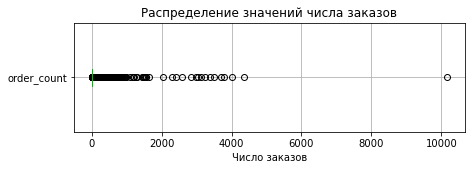

In [57]:
plot_boxplot(
    data=user_profile['order_count'], 
    width=7, 
    height=2,
    vert=False,
    title='Распределение значений числа заказов',
    xlabel='Число заказов'
)

Заметим, что в данных по числу заказов есть экстремальные выбросы: об этом говорит 99ый процентиль, в разы меньший максимального значения. При этом в остальных исследуемых данных 99ый процентиль сравним с максимумом, что говорит о менее явном характере выбросов.

In [58]:
# количество строк, где число заказов больше 99го процентиля
(user_profile['order_count'] > user_profile['order_count'].quantile(.99)).sum()

219

Значения числа заказов, большие 99го процентиля, обнаружены всего в 219 строках. Их можно удалить

In [59]:
user_profile = user_profile[user_profile['order_count'] <= user_profile['order_count'].quantile(.99)]

In [60]:
display(user_profile[['order_count', 'mean_tickets', 'mean_days_since_prev']].describe(percentiles=[.5, .75, .95, .99]))

,order_count,mean_tickets,mean_days_since_prev
count,21612.000000,21612.000000,13281.000000
mean,6.475292,2.740301,16.103946
std,14.205046,0.907112,22.408661
min,1.000000,1.000000,0.000000
50%,2.000000,2.750000,8.375000
75%,5.000000,3.090909,20.750000
95%,26.000000,4.000000,62.000000
99%,79.000000,5.000000,113.000000
max,151.000000,6.000000,148.000000


Заметим, что 99ый процентиль стал сопоставим с максимумом в столбце `order_count`, при этом отфильтрована пренебрежительно малая часть данных.

---

In [61]:
delta = (initial_profile_length - len(user_profile)) / initial_profile_length
print(f"Начальный объем данных: {initial_profile_length}")
print(f"Объем данных после фильтрации: {len(user_profile)}")
print(f"Процент удаленных строк: \
{format(delta, '.1%')}")

Начальный объем данных: 21831
Объем данных после фильтрации: 21612
Процент удаленных строк: 1.0%


**Вывод по профилю пользователя**  
- построен профиль пользователя по сгруппированным данным;
- собраны статистики по 21831 уникальному пользователю;
- средняя выручка с одного заказа 544.8 руб.;
- доля пользователей, совершивших два и более заказа 0.613;
- доля пользователей, совершивших пять и более заказов 0.283;
- среди значений поля `order_count` профиля пользователя обнаружены экстремальные выбросы, датасет `user_profile` отфильтрован по 99му процентилю поля `order_count`; удален 1% данных по уникальным пользователям, а итоговый объем данных - 21612 уникальных пользователей.

## 4. Исследовательский анализ данных <a id='4'></a>

### 4.1 Исследование признаков первого заказа <a id='4.1'></a>

#### 4.1.1 Изучение распределения пользователей по признакам <a id='4.1.1'></a>

In [62]:
# анализируемые признаки
feature_cols = [
    'first_event', 
    'first_device_type', 
    'first_region',
    'first_service'
]
# вывод агрегированной информации в разрезе каждого признака
for feature in feature_cols:
    grouped_profile = user_profile.groupby(feature)['user_id'].count()
    print(f"Общее количество пользователей в каждом сегменте в разрезе {feature}:")
    print(grouped_profile.sort_values())
    print()
    print(f"Доля пользователей в каждом сегменте в разрезе {feature}:")
    print(round((grouped_profile / grouped_profile.sum()).sort_values(), 3))
    print('='*50)

Общее количество пользователей в каждом сегменте в разрезе first_event:
first_event
ёлки          93
выставки     406
спорт        795
стендап     1118
театр       4250
другое      5388
концерты    9562
Name: user_id, dtype: int64

Доля пользователей в каждом сегменте в разрезе first_event:
first_event
ёлки        0.004
выставки    0.019
спорт       0.037
стендап     0.052
театр       0.197
другое      0.249
концерты    0.442
Name: user_id, dtype: float64
Общее количество пользователей в каждом сегменте в разрезе first_device_type:
first_device_type
desktop     3731
mobile     17881
Name: user_id, dtype: int64

Доля пользователей в каждом сегменте в разрезе first_device_type:
first_device_type
desktop    0.173
mobile     0.827
Name: user_id, dtype: float64
Общее количество пользователей в каждом сегменте в разрезе first_region:
first_region
яснопольский округ             1
сосноводолинская область       1
верхозёрский край              1
залесский край                 2
светолесский кр

Для анализа выраженных "точек входа" показательна относительная статистика.
- в разрезе типа первого мероприятия выделаются концерты (44% первых заказов) и театр (20% первых заказов);
- в разрезе типа устройства подавляющее большинство первых заказов (83%) совершены с мобильных устройств;
- в разрезе регионов первого заказа стоит выделить каменевский регион (33%);
- в разрезе билетных операторов "билеты без проблем" выделяются с 24% первых заказов.

#### 4.1.2 Анализ возвратов пользователей <a id='4.1.2'></a>

Доля пользователей, совершивших два или более заказов в разрезе first_event:
first_event
концерты    0.618
другое      0.595
театр       0.635
стендап     0.612
спорт       0.558
выставки    0.635
ёлки        0.548
dtype: float64


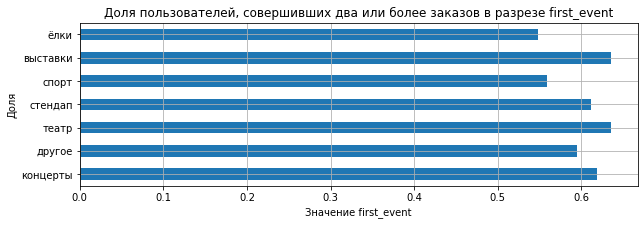

Доля пользователей, совершивших два или более заказов в разрезе first_device_type:
first_device_type
mobile     0.607
desktop    0.640
dtype: float64


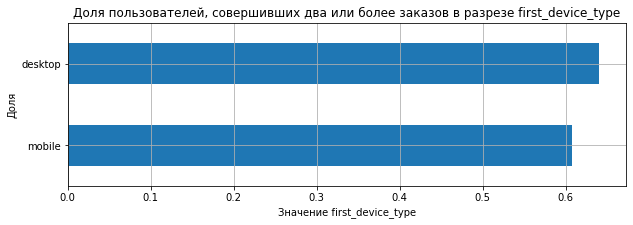

Доля пользователей, совершивших два или более заказов в разрезе first_region:
first_region
каменевский регион      0.624
североярская область    0.638
широковская область     0.646
озернинский край        0.551
малиновоярский округ    0.556
шанырский регион        0.673
травяная область        0.613
светополянский округ    0.657
речиновская область     0.633
яблоневская область     0.592
dtype: float64


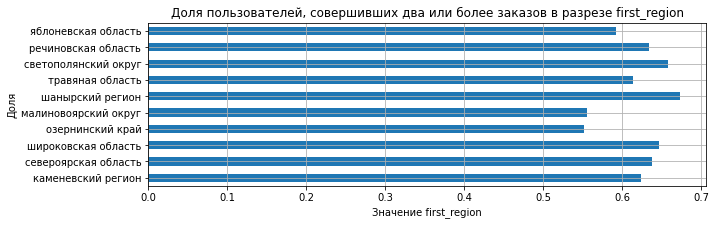

Доля пользователей, совершивших два или более заказов в разрезе first_service:
first_service
билеты без проблем    0.602
мой билет             0.609
лови билет!           0.611
билеты в руки         0.627
облачко               0.612
весь в билетах        0.630
лучшие билеты         0.614
прачечная             0.619
край билетов          0.655
дом культуры          0.639
dtype: float64


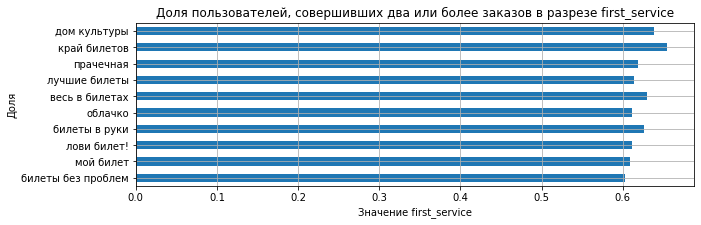

In [63]:
# вывод агрегированной информации в разрезе каждого признака
for feature in feature_cols:
    # группировка по выбранному признаку и по булевому признаку is_two
    grouped_df = user_profile.groupby(by=[feature, 'is_two'])['user_id'].count().unstack(fill_value=0)
    # вычисление количества пользователей для последующей сортировки
    grouped_df['sum'] = grouped_df[0] + grouped_df[1]
    # сортировка по количеству пользователей
    grouped_df = grouped_df.sort_values(by='sum', ascending=False).head(10)
    print(f"Доля пользователей, совершивших два или более заказов в разрезе {feature}:")
    print(round(grouped_df[1] / grouped_df['sum'], 3))
    # построение графика 
    plot_bar(
        data=(grouped_df[1] / grouped_df['sum']),
        kind='barh',
        width=10, height=3,
        rot=0,
        title=f"Доля пользователей, совершивших два или более заказов в разрезе {feature}",
        xlabel=f"Значение {feature}", ylabel='Доля'
    )
    print('='*50)

Проведем анализ сегментов пользователей, чаще возвращающихся на Сервис:
- в разрезе типа первого мероприятия чаще всего возвращаются пользователи сегментов "театр" и "выставки" (доля вернувшихся 0.635), но также стоит отметить сегмент "концерты", в котором наибольшее число пользователей и высока доля вернувшихся (0.618);
- в разрезе типа устройства чаще возвращаются пользователи десктопных версий (0.64);
- в разрезе регионов самым лояльным является Шанырский регион, но отметим, что топ-3 региона по количеству пользователей также имеют высокую степень лояльности (доля у всех трех больше 0.62);
- в разрезе билетных операторов наиболее лояльный сегмент - "край билетов", но важно отметить слабую зависимость доли вернувшихся от билетного оператора (все доли в районе 0.6).

#### 4.1.3 Анализ продуктовых гипотез <a id='4.1.3'></a>

**Гипотеза 1**  
Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

---
Гипотеза неверна. Доля вернувшихся пользователей для сегмента "спорт" ниже, чем для сегмента "концерты" (0.558 против 0.618).

**Гипотеза 2**  
В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---
Гипотеза верна. На масштабе топ-10 активных регионов это заметно слабее, но даже на примере первых 10 активных регионов видно, что у первых трех регионов средняя доля вернувшихся выше, чем для последних трех. Гипотеза становится очевидной при анализе топ-15 активных регионов: ближе к концу списка доля вернувшихся пользователей падает и держится строго ниже 0.6.

### 4.2 Исследование поведения пользователей через показатели выручки и состава заказа <a id='4.2'></a>

#### 4.2.1 Анализ связи средней выручки с повторными заказами <a id='4.2.1'></a>

In [64]:
# определим Series с данными по средней выручке
one_order_avg = user_profile[user_profile['order_count'] == 1]['mean_revenue_rub']
two_order_avg = user_profile[user_profile['is_two'] == 1]['mean_revenue_rub']

In [65]:
# унифицируем границы интервалов построения диаграммы
max_val = user_profile['mean_revenue_rub'].max()
n_bins = 50
step = max_val / n_bins
bins = [0 + i * step for i in range(n_bins + 1)]

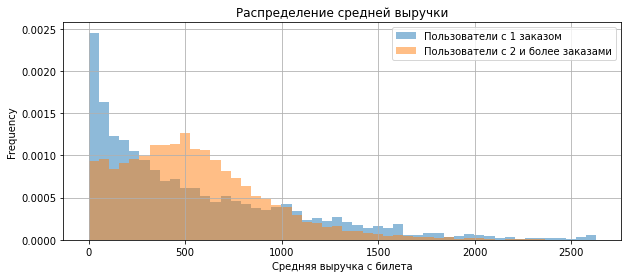

In [66]:
# построение сравнительного графика
plt.figure(figsize=(10, 4))
one_order_avg.plot(
    kind='hist',
    rot=0,
    bins=bins,
    alpha=0.5,
    density=True,
    label='Пользователи с 1 заказом',
    legend=True
    )
two_order_avg.plot(
    kind='hist',
    rot=0,
    bins=bins,
    alpha=0.5,
    density=True,
    label='Пользователи с 2 и более заказами',
    legend=True
    )
plt.title('Распределение средней выручки')
plt.xlabel('Средняя выручка с билета')
plt.grid()
plt.show()

Заметим, что пользователи, совершившие только один заказ, приносят среднюю выручку, сосредоточенную в области малых значений в районе 100 рублей. Как только средний пользователь возвращается, выручка сдвигается вправо и чаще сосредоточена в области 500 рублей. Отсюда выглядит логичным стремление повысить долю возвращающихся пользователей, так как есть прямая связь возврата и повышения выручки.

#### 4.2.2 Анализ средней выручки среди вернувшихся пользователей <a id='4.2.2'></a>

In [67]:
# определим Series с данными по средней выручке
two_four_order_avg = user_profile[(user_profile['order_count'] >= 2) & (user_profile['order_count'] <= 4)]['mean_revenue_rub']
five_order_avg = user_profile[user_profile['is_five'] == 1]['mean_revenue_rub']

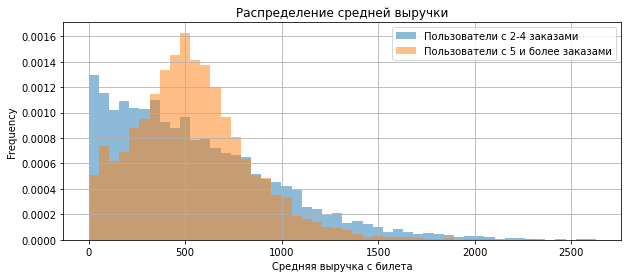

In [68]:
# построение сравнительного графика
plt.figure(figsize=(10, 4))
two_four_order_avg.plot(
    kind='hist',
    rot=0,
    bins=bins,
    alpha=0.5,
    density=True,
    label='Пользователи с 2-4 заказами',
    legend=True
    )
five_order_avg.plot(
    kind='hist',
    rot=0,
    bins=bins,
    alpha=0.5,
    density=True,
    label='Пользователи с 5 и более заказами',
    legend=True
    )
plt.title('Распределение средней выручки')
plt.xlabel('Средняя выручка с билета')
plt.grid()
plt.show()

Распределение выручки пользователей с 2-4 заказами не имеет явного экстремума, но в основном сосредоточено в области значений до 500 рублей. Для пользователей с 5 и более заказами виден явный максимум плотности распределения на значении средней выручки в 500 рублей.

#### 4.2.3 Анализ влияния среднего количества билетов на вероятность повторной покупки <a id='4.2.3'></a>

Проведем классификацию пользователей по среднему количеству билетов в заказе. Для этого напишем функцию:

In [69]:
def classify_ticket(avg):
    if 1 <= avg < 2:
        return 'от 1 до 2 билетов'
    elif 2 <= avg < 3:
        return 'от 2 до 3 билетов'
    elif 3 <= avg < 5:
        return 'от 3 до 5 билетов'
    else:
        return 'от 5 и более билетов'

In [70]:
# добавим столбец с классификацией в профиль пользователя
user_profile['ticket_segment'] = user_profile['mean_tickets'].apply(classify_ticket)

In [71]:
# группируем и агрегируем по полученной сегментации
user_profile.groupby(by='ticket_segment').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).reset_index()

,ticket_segment,user_id,is_two
0,от 1 до 2 билетов,2411,0.512650
1,от 2 до 3 билетов,9491,0.735750
2,от 3 до 5 билетов,9062,0.542485
3,от 5 и более билетов,648,0.177469


Выделим основные результаты анализа:
- пользователи распределены по сегментам неравномерно: наибольшее количество пользователей (более 9000) сосредоточены в сегментах от 2 до 3 билетов и от 3 до 5 билетов;
- наибольшая доля повторных покупок (порядка 0.74) у пользователей, в среднем покупающих от 2 до 3 билетов (можно предположить, что это пары, покупающие по два билета и посещающие мероприятия регулярно)
- наименьшая доля повторных покупок (порядка 0.18) у сегмента с пятью и более купленными билетами (можно предположить, что в сегменте преобладают разовые экскурсионные походы школьников/студентов).

### 4.3 Исследование временных характеристик первого заказа и их влияния на повторные покупки <a id='4.3'></a>

#### 4.3.1 Анализ влияния среднего количества билетов на вероятность повторной покупки <a id='4.3.1'></a>

In [72]:
# выделяем день недели из даты (1 - понедельник, 7 - воскресенье)
user_date_profile = user_profile
user_date_profile['dow'] = user_date_profile['first_order_dt'].dt.day_of_week + 1
user_date_profile

,user_id,first_order_dt,first_device_type,first_region,first_service,first_event,last_order_dt,order_count,mean_revenue_rub,mean_tickets,mean_days_since_prev,is_two,is_five,ticket_segment,dow
0,0002849b70a3ce2,2024-08-20,mobile,каменевский регион,край билетов,театр,2024-08-20,1,1521.940000,4.000000,NaN,0,0,от 3 до 5 билетов,2
1,0005ca5e93f2cf4,2024-07-23,mobile,каменевский регион,мой билет,выставки,2024-10-06,2,774.010000,3.000000,75.000,1,0,от 3 до 5 билетов,2
2,000898990054619,2024-07-13,mobile,североярская область,лови билет!,другое,2024-10-23,3,767.213333,2.666667,51.000,1,0,от 2 до 3 билетов,6
3,00096d1f542ab2b,2024-08-15,desktop,каменевский регион,край билетов,театр,2024-08-15,1,917.830000,4.000000,NaN,0,0,от 3 до 5 билетов,4
4,000a55a418c128c,2024-09-29,mobile,поленовский край,лучшие билеты,театр,2024-10-15,2,61.310000,1.500000,16.000,1,0,от 1 до 2 билетов,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21826,fff13b79bd47d7c,2024-07-16,mobile,каменевский регион,мой билет,другое,2024-10-31,9,688.043333,2.555556,13.375,1,1,от 2 до 3 билетов,2
21827,fff32fc9ad0f9f6,2024-08-15,desktop,каменевский регион,билеты без проблем,стендап,2024-10-28,2,850.995000,2.500000,74.000,1,0,от 2 до 3 билетов,4
21828,fffcd3dde79eb2c,2024-06-20,desktop,каменевский регион,билеты без проблем,концерты,2024-10-30,33,557.908485,2.787879,4.125,1,1,от 2 до 3 билетов,4
21829,fffeeb3c120cf0b,2024-09-24,desktop,широковская область,билеты без проблем,стендап,2024-09-24,1,661.530000,2.000000,NaN,0,0,от 2 до 3 билетов,2


In [73]:
# группировка по дню недели и расчет статистик
agg_data_profile = user_date_profile.groupby(by='dow').agg({
    'user_id': 'count',
    'is_two': 'mean'
})
agg_data_profile.columns = ['user_count', 'mean_loyal']
# для наглядности добавим относительное количество пользователей
agg_data_profile['user_count_rel'] = agg_data_profile['user_count'] / agg_data_profile['user_count'].sum()
agg_data_profile

,user_count,mean_loyal,user_count_rel
dow,,,
1,2917,0.629757,0.134971
2,3176,0.618388,0.146955
3,3061,0.622346,0.141634
4,3111,0.594664,0.143948
5,3255,0.597542,0.150611
6,3317,0.627676,0.153480
7,2775,0.600721,0.128401


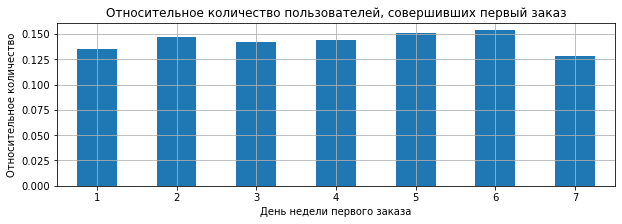

In [74]:
# построение столбчатой диаграммы
plot_bar(
    data=agg_data_profile['user_count_rel'],
    kind='bar',
    width=10, height=3,
    rot=0,
    title='Относительное количество пользователей, совершивших первый заказ',
    xlabel='День недели первого заказа', ylabel='Относительное количество'
    )

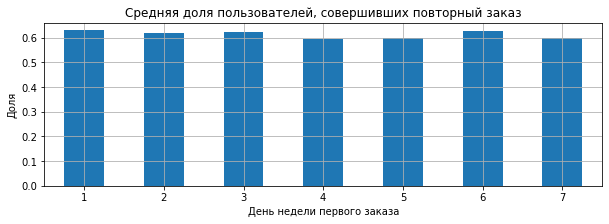

In [75]:
# построение столбчатой диаграммы
plot_bar(
    data=agg_data_profile['mean_loyal'],
    kind='bar',
    width=10, height=3,
    rot=0,
    title='Средняя доля пользователей, совершивших повторный заказ',
    xlabel='День недели первого заказа', ylabel='Доля'
    )

По построенным визуализациям трудно судить о корреляции количества пользователей и средний доли вернувшихся пользователей с днем первого заказа. 
- средняя доля вернувшихся клиентов слабо меняется от дня недели и максимальна в понедельник (0.63). Можно заключить об отсутствии выраженного влияния дня недели первого заказа на этот параметр;
- больше людей предпочитают совершать первый заказ в субботу (относительное количество 0.153), что можно объяснить первым выходным днем.

#### 4.3.2 Анализ влияния среднего интервала между заказами на удержание клиентов <a id='4.3.2'></a>

In [76]:
# разделим пользователей на сегменты и выделим среднее время ммежду заказами
two_four_order_days = user_profile[(user_profile['order_count'] >= 2) & (user_profile['order_count'] <= 4)]['mean_days_since_prev']
five_order_days = user_profile[user_profile['is_five'] == 1]['mean_days_since_prev']

In [77]:
# определим среднее внутри каждого сегмента
print(f"Среднее время между заказами для пользователей, совершивших 2-4 заказа: \
{round(two_four_order_days.mean(), 2)}")
print()
print(f"Среднее время между заказами для пользователей, совершивших 5 и более заказов: \
{round(five_order_days.mean(), 2)}")

Среднее время между заказами для пользователей, совершивших 2-4 заказа: 21.33

Среднее время между заказами для пользователей, совершивших 5 и более заказов: 9.91


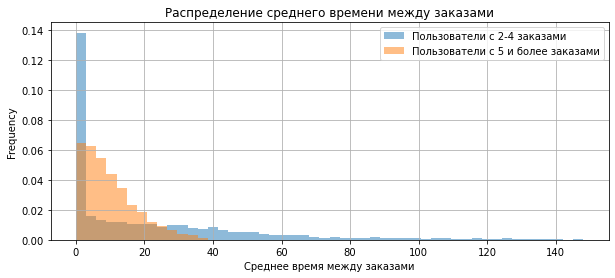

In [78]:
# унифицируем границы интервалов построения диаграммы
max_val = user_profile['mean_days_since_prev'].max()
min_val = user_profile['mean_days_since_prev'].min()
n_bins = 50
step = (max_val - min_val) / n_bins
bins = [min_val + i * step for i in range(n_bins + 1)]

# построение сравнительного графика распределения среднего времени между заказами
plt.figure(figsize=(10, 4))
two_four_order_days.plot(
    kind='hist',
    rot=0,
    bins=bins,
    alpha=0.5,
    density=True,
    label='Пользователи с 2-4 заказами',
    legend=True
    )
five_order_days.plot(
    kind='hist',
    rot=0,
    bins=bins,
    alpha=0.5,
    density=True,
    label='Пользователи с 5 и более заказами',
    legend=True
    )
plt.title('Распределение среднего времени между заказами')
plt.xlabel('Среднее время между заказами')
plt.grid()
plt.show()

Исходя из сравнительной гистограммы, отметим основные моменты:
- сегмент пользователей с 2-4 заказами имеет большую положительную скошенность, что увеличивает среднее количество дней между заказами (21.33) относительно пользователей с 5 и более заказами (9.91);
- распределение в сегменте пользователей с 2-4 заказами имеет выраженный пик в области малого среднего времени, т.е. имеется большая группа пользователей этого сегмента, часто совершающих заказы;
- в сегменте пользователей с 5 и более заказами практически все пользователи сосредоточены в области до 40 дней, то есть в целом эта группа совершает заказы чаще, а значит прослеживается положительная связь между "возвращением" на Сервис и уменьшением времени между заказами (меньше интервал - больше заказов).

### 4.4 Корреляционный анализ количества покупок и признаков пользователя <a id='4.4'></a>

#### 4.4.1 Проведение корреляционного анализа <a id='4.4.1'></a>

In [79]:
# формирование столбцов для анализа корреляций
corr_columns = user_profile.columns.to_list()
corr_columns.remove('user_id')
corr_columns.remove('ticket_segment')
corr_columns.remove('dow')

print(f"Анализ корреляции будет проведен по столбцам: {', '.join(corr_columns)}")

Анализ корреляции будет проведен по столбцам: first_order_dt, first_device_type, first_region, first_service, first_event, last_order_dt, order_count, mean_revenue_rub, mean_tickets, mean_days_since_prev, is_two, is_five


In [80]:
# расчет матрицы корреляций с объявлением интервальных переменных
corr_matrix = user_profile[corr_columns].phik_matrix(interval_cols=[
    'order_count',
    'mean_revenue_rub',
    'mean_tickets',
    'mean_days_since_prev'
])

In [81]:
order_count_corr = corr_matrix['order_count'][corr_matrix.index != 'order_count']

<AxesSubplot:>

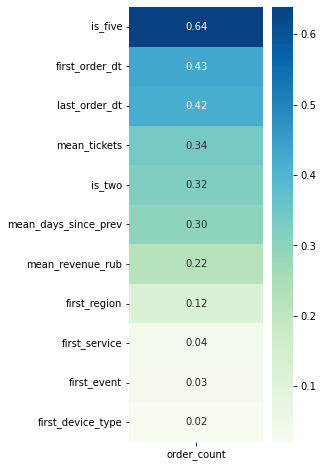

In [82]:
plt.figure(figsize=(3, 8))
sns.heatmap(
    order_count_corr.sort_values(ascending=False).to_frame(),
    annot=True,
    fmt='.2f',
    cmap='GnBu'
)

**Вывод по результатам анализа корреляции**  
Определим основные бустеры роста количества заказов и попытаемся интерпретировать полученные корреляции.
1. Выраженная корреляция количества заказов наблюдается:
    - с булевым признаком 5 и более заказов (0.64). Логичное следствие, поскольку количество заказов напрямую влияет на значение булевого признака;
    - с датой первого и датой последнего заказа (0.42-0.43). Возможное объяснение: чем раньше дата первого заказа, тем больше может быть количество заказов. Также может быть и такая связь: чем меньше прошло времени с даты последнего заказа, тем возможно чаще пользователь совершает заказы. Надо понимать, чоэффициент корреляции выведен без учета знака и указывает лишь на наличие связи без учета ее характера.
2. Умеренная корреляция количества заказов наблюдается:    
    - со средним количеством купленных билетов (0.34). Пользователи, покупающие большее число билетов показывают большую вовлеченность и чаще совершают заказы;
    - с булевым признаком 2 и более заказов (0.32). Возвращение на платформу влияет на количество заказов;
    - со средним количеством дней между заказами (0.30). Меньше число дней - чаще заказы;
    - со средним чеком (0.22). Пользователи, чаще совершающие покупки, более вовлечены и приносят больший средний чек
3. Слабая корреляция количества заказов наблюдается:
    - с регионом первого заказа (0.12);
    - с билетным оператором первого заказа (0.04);
    - с типом мероприятия первого заказа (0.03);
    - с устройством первого заказа (0.02).


## 5. Общие выводы и рекомендации <a id='5'></a>

### 5.1 Обзор обрабатываемых данных <a id='5.1'></a>

Исследовательский анализ данных выполнен на основе записей о 290611 заказах, совершенных 21831 уникальными пользователями.
В ходе обработки данных:
- поле с количеством билетов приведено к типу данных `int8`;
- создано поле `revenue_rub` с валютой, переведенной в рубли;
- удалено 3386 строк (порядка 1.17% данных) после фильтрации полей `revenue_rub` и `tickets_count` по 99му процентилю и удаления отрицательных значений выручки, что повысило качество выборки.

### 5.2 Основные результаты анализа <a id='5.2'></a>

**Профиль пользователя**  
- отфильтрованы выбросы в данных по числу заказов: итоговая выборка ограничивается 21612 уникальным пользователем;
- средняя выручка с заказа 544.8 рублей;
- доля пользователей, совершивших 2 и более заказа 0.62;
- доля пользователей, совершивших 5 и более заказов 0.29;
- среднее количество билетов в заказе 2.74, а средний интервал между заказами 15.85.

**Точки входа пользователей**  
- первый заказ 44% пользователей был на концерт;
- 83% пользователей делали первый заказ с мобильного устройства.

**Анализ лояльности**  
- несмотря на то, что лишь 17% пользователей делали первый заказ с десктопной версии, они с большей вероятностью возвращаются на платформу (64% пользователей);
- пользователи, купившие первый билет в театр или на выставку, возвращаются на платформу чаще (63.5%);
- самый лояльный регион - шанырский регион: 67.3% вернувшихся пользователей;
- важный сегмент лояльных пользователей - пользователи, купившие в среднем от 2 до 3 билетов - они возвращаются практически в 74% случаев;
- также пользователи, сделавшие больше одного заказа, демонстрируют серьезный рост средней выручки по сравнению с пользователями, оформившими 1 заказ.

**Анализ временных факторов**  
- пользователи, совершившие от пяти заказов, демонстрируют более высокую частоту заказов.

### 5.3 Основные рекомендации <a id='5.3'></a>

Сформулируем основные рекомендации заказчику в части повышения лояльности клиентов Яндекс Афиши:
- среди топ-10 регионов по количеству пользователей есть регионы с малой на фоне остальных лояльностью: озернинский край, малиновоярский округ; рекомендуется изменить подход к рекламе в этих регионах;
- пользователи мобильных устройств показывают более низкую лояльность по сравнению с пользователями десктоп-версий; возможно есть минусы в приложении;
- самый лояльный и многочисленный сегмент: пользователи, приобретающие сразу 2-3 билета (скорее всего, пары); для сегмента рекомендутеся продумать систему скидок/бонусов.

## 6. Публикация проекта в Git <a id='6'></a>